In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
controller_output = Path('output')

In [3]:
low_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
high_df = pd.read_csv(controller_output / '100_runs_highest_utility.csv')
random_df = pd.read_csv(controller_output / '100_runs_random_utility.csv')

In [4]:
for df in [low_df, high_df, random_df]:
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

## Rule Picking Strategies (for choosing action per issue)

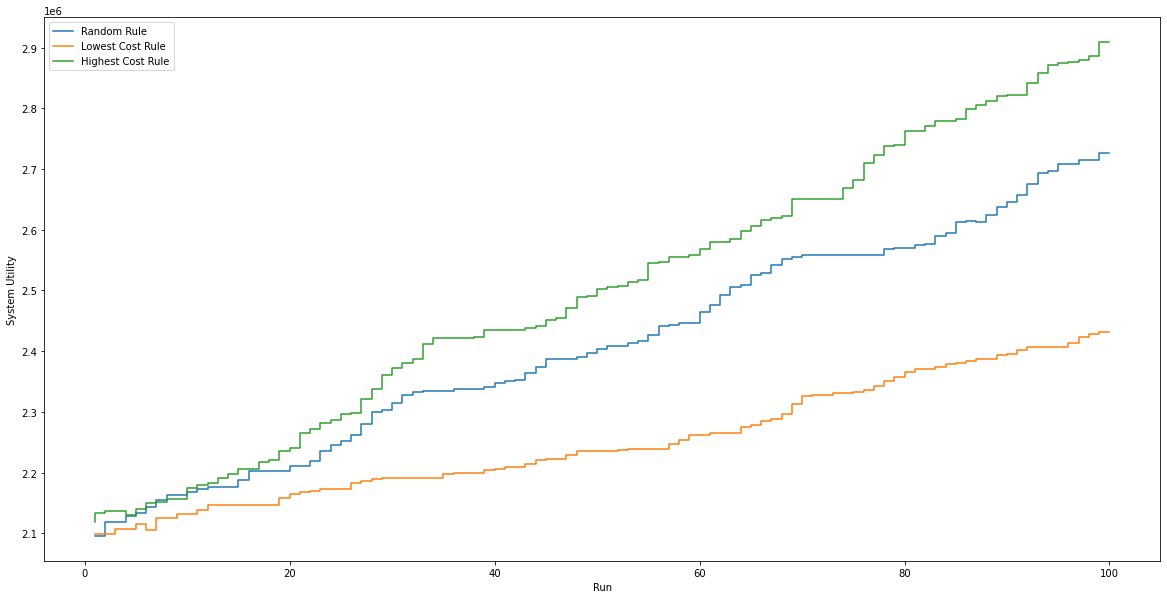

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='run', y='system_utility', data=random_df, ax=ax, ci=None, drawstyle='steps', label='Random Rule')
sns.lineplot(x='run', y='system_utility', data=low_df, ax=ax, ci=None, drawstyle='steps', label='Lowest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=high_df, ax=ax, ci=None, drawstyle='steps', label='Highest Cost Rule')
ax.set(xlabel='Run', ylabel='System Utility');

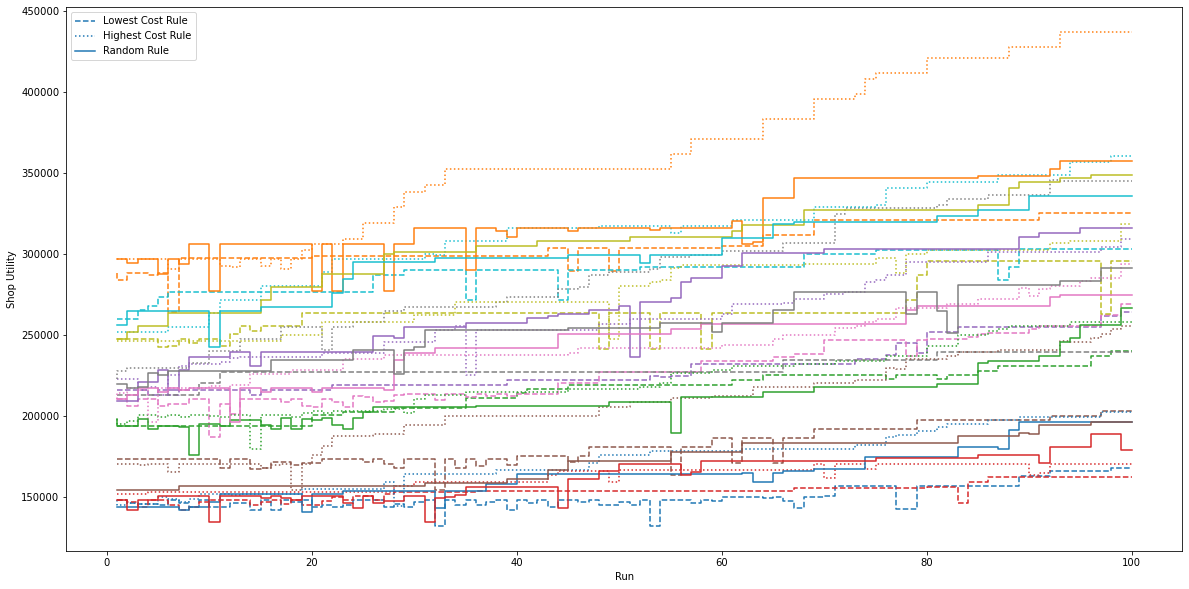

In [253]:
fig, ax = plt.subplots(figsize=(20,10))
lowest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_df, ci=None, linestyle='dashed', ax=ax, label='Lowest Cost Rule', legend=False, drawstyle='steps')
highest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=high_df, ci=None, linestyle='dotted', ax=ax, label='Highest Cost Rule', legend=False, drawstyle='steps')
random = sns.lineplot(x='run', y='shop_utility', hue='shop', data=random_df, ci=None, ax=ax, label='Random Rule', legend=False, drawstyle='steps')
ax.set(xlabel='Run', ylabel='Shop Utility');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::10], ['Lowest Cost Rule', 'Highest Cost Rule', 'Random Rule']);

## Issue Ranking Strategies

In [7]:
low_u_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
low_c_df = pd.read_csv(controller_output / '100_runs_lowest_cost.csv')
low_r_df = pd.read_csv(controller_output / '100_runs_lowest_random.csv')

In [250]:
low_u_500_df = pd.read_csv(controller_output / '500_runs_lowest_utility.csv')
low_c_500_df = pd.read_csv(controller_output / '500_runs_lowest_cost.csv')
low_r_500_df = pd.read_csv(controller_output / '500_runs_lowest_random.csv')

In [251]:
for df in [low_u_500_df, low_c_500_df, low_r_500_df]:
    scaler = StandardScaler()
    df['normalized_system_utility'] = scaler.fit_transform(df['system_utility'].values.reshape(-1,1))

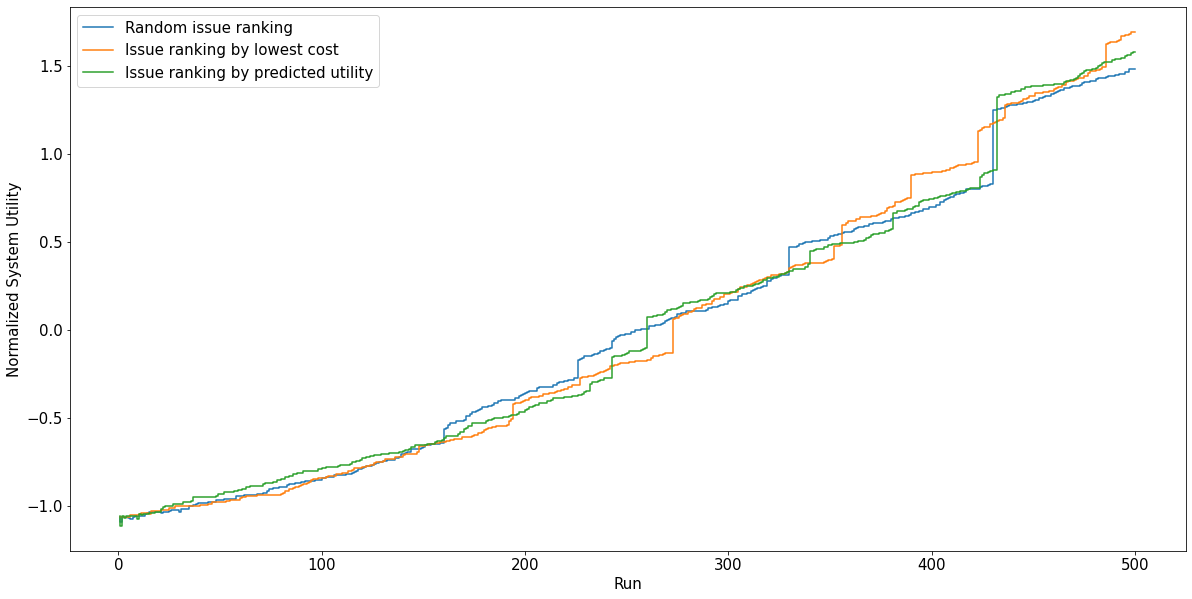

In [252]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='run', y='normalized_system_utility', data=low_r_500_df, ax=ax, ci=None, label='Random issue ranking', drawstyle='steps')
sns.lineplot(x='run', y='normalized_system_utility', data=low_c_500_df, ax=ax, ci=None, label='Issue ranking by lowest cost', drawstyle='steps')
sns.lineplot(x='run', y='normalized_system_utility', data=low_u_500_df, ax=ax, ci=None, label='Issue ranking by predicted utility', drawstyle='steps')
ax.set(xlabel='Run', ylabel='Normalized System Utility')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
ax.legend(fontsize=15)
fig.savefig(controller_output / 'sys_utility_strategies.png', dpi=300)

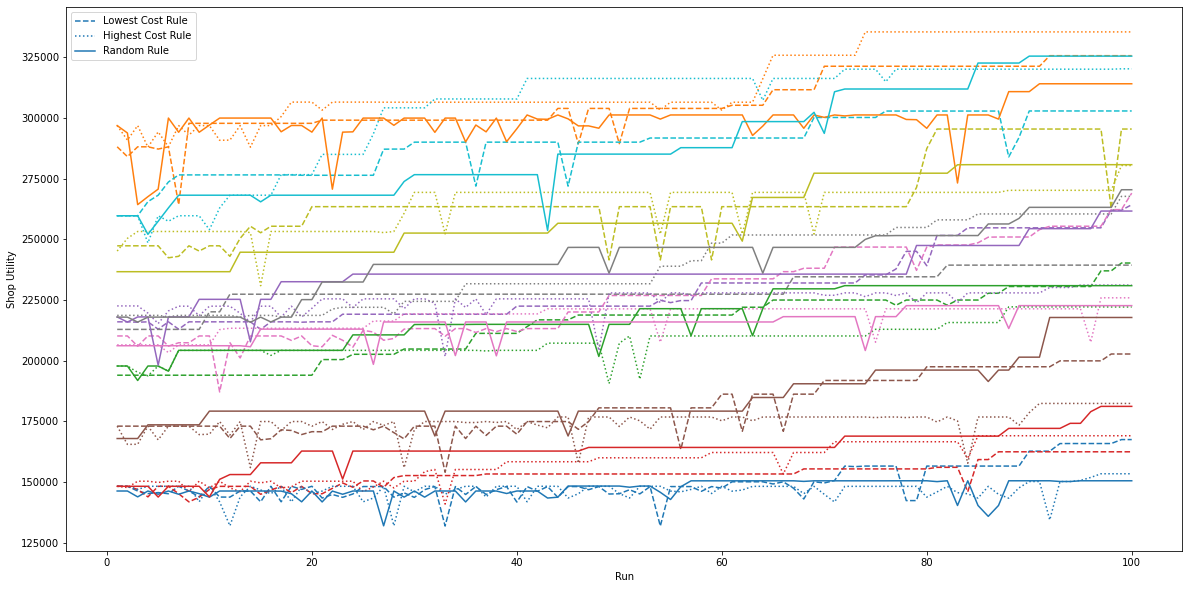

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
lowest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_u_df, ci=None, linestyle='dashed', ax=ax, label='Lowest Cost Rule', legend=False)
highest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_c_df, ci=None, linestyle='dotted', ax=ax, label='Highest Cost Rule', legend=False)
random = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_r_df, ci=None, ax=ax, label='Random Rule', legend=False)
ax.set(xlabel='Run', ylabel='Shop Utility');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::10], ['Lowest Cost Rule', 'Highest Cost Rule', 'Random Rule']);

In [42]:
for df in [low_u_df, low_c_df, low_r_df]:
    df['combined_index'] = 'after fixing ' + df['failure_name'].astype(str) + ' (' + df['shop'].astype(str) + ')'
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

In [201]:
def replicate_issue_ranking(df, run, strategy='utility'):
    example = df.query(f'run == {run}').copy()
    example_fixes = example.loc[~example['predicted_optimal_utility'].isna()].copy()
    example_fixes['min_cost'] = example_fixes['rule_costs'].apply(min)
    if strategy == 'utility':
        example_fixes = example_fixes.sort_values(['predicted_optimal_utility'], ascending=False)
    elif strategy == 'cost':
        example_fixes = example_fixes.sort_values(['min_cost'], ascending=True)
    elif strategy == 'random':
        example_fixes = example_fixes.sample(frac=1, random_state=42)
    else:
        raise NotImplementedError('Strategy {strategy} is not implemented')
    example_fixes['estimated_system_utility'] = example_fixes['system_utility'] + example_fixes['predicted_optimal_utility'].fillna(0).cumsum()
    if len(example_fixes) > 1:
        example_fixes['auc'] = auc(x=np.arange(len(example_fixes)), y=example_fixes['estimated_system_utility'].values)
    else:
        example_fixes['auc'] = np.nan
    #scaler = StandardScaler()
    #example_fixes[['min_cost', 'estimated_system_utility']] = scaler.fit_transform(example_fixes[['min_cost', 'estimated_system_utility']])
    return example_fixes

In [224]:
def plot_strategies_per_run(df, run):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,7))
    plotting_map = {
        'Random Ranking': 'random',
        'Cost Ranking': 'cost',
        'Utility Ranking': 'utility',
    }
    auc_values = {}
    for label, strategy in plotting_map.items():
        ranked_issues = replicate_issue_ranking(df, run, strategy)
        ranked_issues.plot(
            x='combined_index',
            y='estimated_system_utility',
            drawstyle='steps-post',
            rot=90,
            ax=axs[0],
            label=label,
            alpha=0.75
        )
        auc_values[label] = ranked_issues['auc'].max()

    for label, strategy in plotting_map.items():
        ranked_issues = replicate_issue_ranking(df, run, strategy)
        ranked_issues.plot(
            x='combined_index',
            y='estimated_system_utility',
            drawstyle='steps-post',
            rot=90,
            ax=axs[1],
            label=label,
            alpha=0.75
    )

    diff_from_random = {}
    max_diff = 0
    min_diff = 0
    for label, val in auc_values.items():
        diff = val - auc_values['Random Ranking']
        if diff != 0:
            diff_from_random[label] = diff
            if diff > max_diff:
                max_diff = diff
            if diff < min_diff:
                min_diff = diff
    abs_max_diff = max([abs(min_diff), abs(max_diff)])

    sns.barplot(data=pd.DataFrame(diff_from_random, index=[0]), ax=axs[2], palette=['orange', 'green'])

    axs[0].set(
        xlabel='Addressed Issues',
        ylabel='System Utility',
        title=f'Run {run}: System Utility',
        ylim=[0, None]
    )
    axs[1].set(
        xlabel='Addressed Issues',
        ylabel='System Utility',
        title=f'Run {run}: System Utility (detail)',
    )
    axs[2].set(
        xlabel='Strategy',
        ylabel='Area under curve (AUC)',
        title=f'Run {run}: AUC (difference from random ranking)',
        ylim=[-abs_max_diff * 1.1, abs_max_diff * 1.1]
    )

    fig.tight_layout()
    return fig

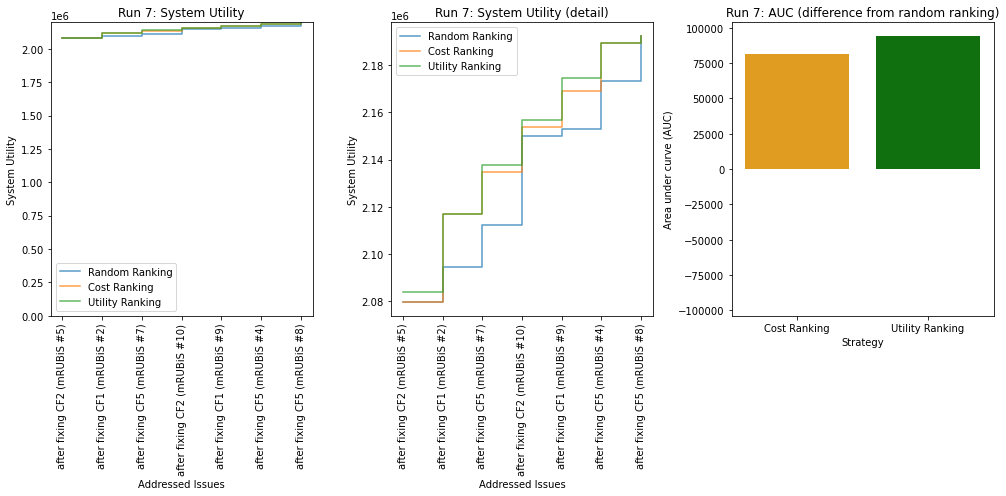

In [230]:
plot_strategies_per_run(low_u_df, 7).savefig(controller_output / 'run_7.png', dpi=300)

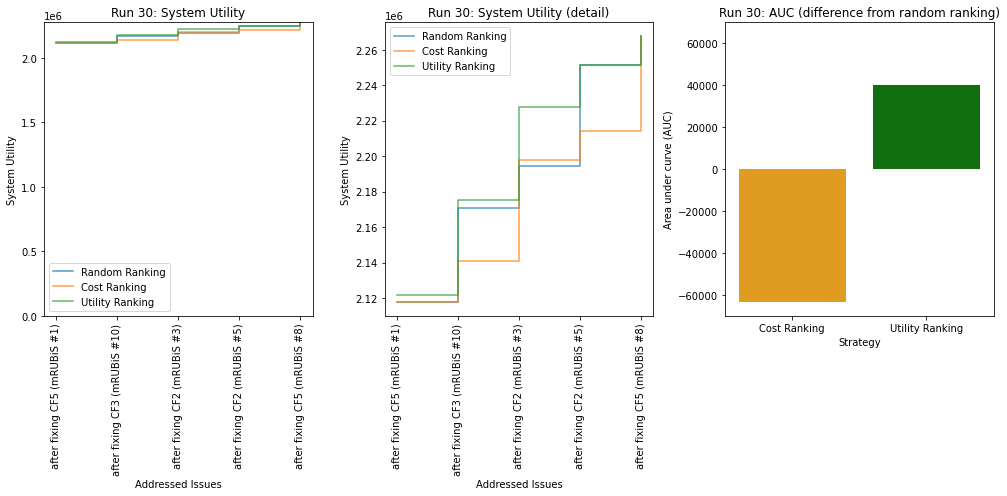

In [229]:
plot_strategies_per_run(low_u_df, 30).savefig(controller_output / 'run_30.png', dpi=300)

In [132]:
replicated_runs_util = []
for r in range(100):
    replicated_runs_util.append(replicate_issue_ranking(low_u_df, r, 'utility'))

In [140]:
replicated_runs_cost = []
for r in range(100):
    replicated_runs_cost.append(replicate_issue_ranking(low_u_df, r, 'cost'))

In [141]:
replicated_runs_random = []
for r in range(100):
    replicated_runs_random.append(replicate_issue_ranking(low_u_df, r, 'random'))

<AxesSubplot:xlabel='combined_index'>

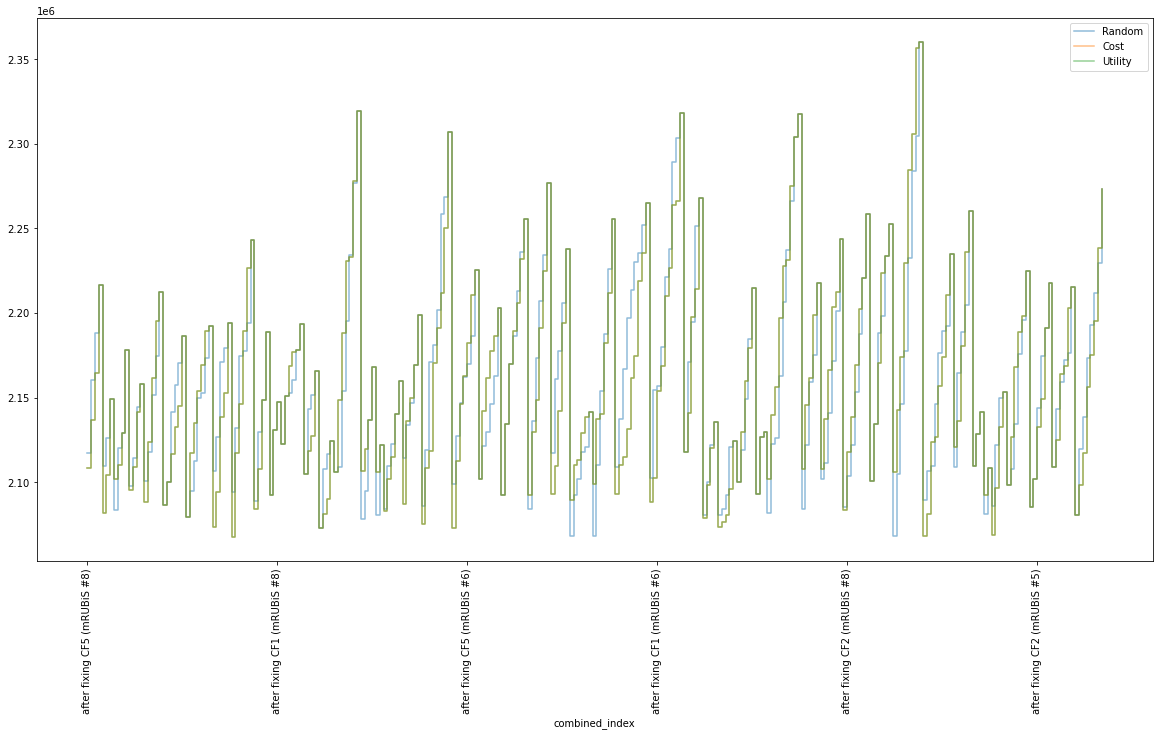

In [147]:
fig, ax = plt.subplots(figsize=(20,10))

pd.concat(replicated_runs_random).query('run < 50').plot(
    x='combined_index',
    y='estimated_system_utility',
    drawstyle='steps-post',
    rot=90,
    ax=ax,
    label='Random',
    alpha=.5
)

pd.concat(replicated_runs_cost).query('run < 50').plot(
    x='combined_index',
    y='estimated_system_utility',
    drawstyle='steps-post',
    rot=90,
    ax=ax,
    label='Cost',
    alpha=.5
)

pd.concat(replicated_runs_util).query('run < 50').plot(
    x='combined_index',
    y='estimated_system_utility',
    drawstyle='steps-post',
    rot=90,
    ax=ax,
    label='Utility',
    alpha=.5
)